In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\MAHA-PC\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
batch_size = 32
img_size = (128, 128)
num_classes = 3
additional_epochs = 10

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [24]:
train_dataset_augmented = datagen.flow_from_directory(
    'Train/Train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=None,
)

class_names = train_dataset_augmented.class_indices.keys()

Found 1322 images belonging to 3 classes.


In [12]:
validation_dataset=tf.keras.utils.image_dataset_from_directory(
    'Validation/Validation',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    
)

Found 60 files belonging to 3 classes.


In [13]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size[0], img_size[1], 3),
)
base_model.trainable = True

In [7]:
fine_tune_at = 15

In [8]:
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [9]:
model = tf.keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  
    layers.Dense(num_classes, activation='softmax')
])

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_fine = model.fit(
    train_dataset_augmented,
    epochs=additional_epochs,
    validation_data=validation_dataset,
     callbacks=[early_stopping]
)

Epoch 1/10


C:\Users\MAHA-PC\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 225s 5s/step - accuracy: 0.9535 - loss: 0.1275 - val_accuracy: 0.8133 - val_loss: 27.2023
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 214s 4s/step - accuracy: 0.9786 - loss: 0.0885 - val_accuracy: 0.8200 - val_loss: 35.6431
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 228s 5s/step - accuracy: 0.9812 - loss: 0.0659 - val_accuracy: 0.8467 - val_loss: 23.9296
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 222s 5s/step - accuracy: 0.9831 - loss: 0.0536 - val_accuracy: 0.8267 - val_loss: 32.0818
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 231s 5s/step - accuracy: 0.9746 - loss: 0.0813 - val_accuracy: 0.7133 - val_loss: 62.8453
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 219s 5s/step - accuracy: 0.9697 - loss: 0.0875 - val_accuracy: 0.8467 - val_loss: 26.2278


In [32]:
train_loss, train_acc = model.evaluate(train_dataset_augmented)
print(f"Training Loss: {train_loss}, Training Accuracy: {train_acc}")

42/42 ━━━━━━━━━━━━━━━━━━━━ 208s 5s/step - accuracy: 0.9774 - loss: 0.0611
Training Loss: 0.04788642376661301, Training Accuracy: 0.9803328514099121


In [17]:
val_loss, val_acc = model.evaluate(validation_dataset)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")



2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 966ms/step - accuracy: 0.8361 - loss: 33.0593
Validation Loss: 33.875030517578125, Validation Accuracy: 0.8166666626930237


In [35]:
predicted_categories = tf.argmax(model.predict(validation_dataset), axis=1)
true_categories = tf.concat([y for x, y in validation_dataset], axis=0)
Y_true = tf.argmax(true_categories, axis=1)
class_names = ["Healthy", "Powdery", "Rust"]
report = classification_report(Y_true, predicted_categories, target_names=class_names)
print(report)

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
              precision    recall  f1-score   support

     Healthy       0.90      0.72      0.80        50
     Powdery       0.98      0.82      0.89        50
        Rust       0.74      1.00      0.85        50

    accuracy                           0.85       150
   macro avg       0.87      0.85      0.85       150
weighted avg       0.87      0.85      0.85       150



In [36]:
cm = confusion_matrix(Y_true, predicted_categories)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[36  1 13]
 [ 4 41  5]
 [ 0  0 50]]


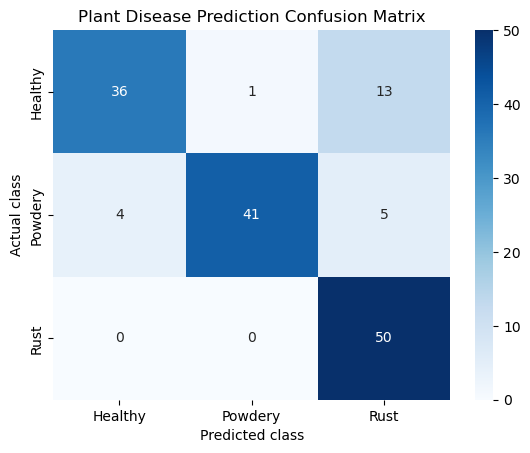

In [37]:
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted class")
plt.ylabel("Actual class")
plt.title("Plant Disease Prediction Confusion Matrix")
plt.show()

In [38]:
model.save("VGG16_finetuned_model.keras")

In [42]:
import json

with open("training_hist_finetuned.json", "w") as f:
    json.dump(history_fine.history, f)

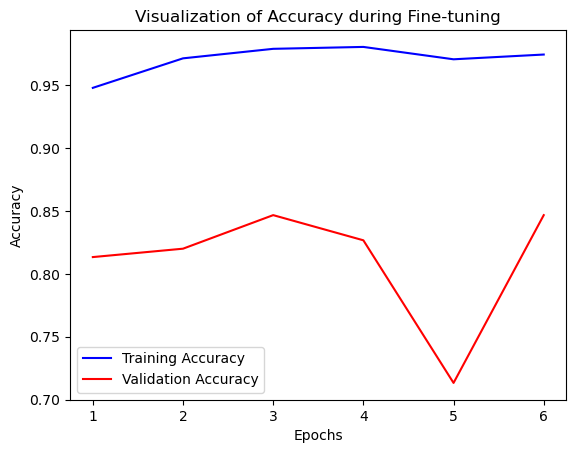

In [45]:
epochs = range(1, len(history_fine.history['accuracy']) + 1)

plt.plot(epochs, history_fine.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(epochs, history_fine.history['val_accuracy'], color='red', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Visualization of Accuracy during Fine-tuning')
plt.legend()
plt.show()


In [43]:
test_dataset=tf.keras.utils.image_dataset_from_directory(
    'Test/Test',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    
)
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

Found 150 files belonging to 3 classes.
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7844 - loss: 36.8854
Test Loss: 23.929637908935547, Test Accuracy: 0.846666693687439


In [44]:
predictions =model.predict(test_dataset)

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
